# ※ 광주광역시 지역(동)별 인구밀도와 전기차충전소의 사용량과의 상관관계 분석 ※

### 0. 라이브러리 import 

In [1]:
import urllib.request
import urllib.parse
import requests

import plotly.express as px
import json, os
import time, datetime
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.rc('font', family='Gulim')
import folium 
from folium.features import DivIcon

### 1. 데이터 불러오기 및 가공

In [2]:
# 광주광역시 인구통계 불러오기
population_df = pd.read_csv('data/광주광역시_행정동별 현황_2020.csv', encoding='cp949')
population_df

,시도명,행정기관,동명,인구,면적,인구밀도
0,광주광역시,동구,충장동,"4,546",1.10,4132.727273
1,광주광역시,동구,동명동,"3,873",0.43,9006.976744
2,광주광역시,동구,계림1동,"10,323",0.62,16650.000000
3,광주광역시,동구,계림2동,"7,859",0.57,13787.719300
4,광주광역시,동구,산수1동,"8,850",0.58,15258.620690
...,...,...,...,...,...,...
91,광주광역시,광산구,임곡동,"2,140",29.82,71.763917
92,광주광역시,광산구,동곡동,"1,932",15.49,124.725629
93,광주광역시,광산구,평동,"4,122",29.87,137.997991
94,광주광역시,광산구,삼도동,"2,278",38.73,58.817454


In [3]:
# 전기차 충전소 충전량 데이터 불러오기
# pd.set_option('display.max_columns', None)
ev_usage = pd.read_csv('data/광주광역시_전기차충전소충전량(2020).csv', encoding='utf8')
ev_usage

,Unnamed: 0,본부,사업소,충전소명,충전기,충전기ID,주소,충전기구분,충전용량,충전량,...,충전종료시각,지역(구),지역(동),충전시각,충전시각(분),day,month,hour,시간당 충전량,time
0,0,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,11.910,...,2020-01-01 23:05,광산구,하남동,0 days 01:57:00,117,1,1,21,6.107692,21:08
1,1,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,22.060,...,2020-01-01 0:35,광산구,하남동,0 days 03:17:00,197,31,12,21,6.719464,21:18
2,2,광주전남,광산,하남2지구 중흥S-클래스,완속01,2703,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,16.120,...,2020-01-02 20:20,광산구,하남동,0 days 02:38:00,158,2,1,17,6.122294,17:42
3,3,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,11.210,...,2020-01-02 22:25,광산구,하남동,0 days 01:46:00,106,2,1,20,6.344086,20:39
4,4,광주전남,광산,하남2지구 중흥S-클래스,완속01,2703,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,5.610,...,2020-01-03 14:15,광산구,하남동,0 days 00:54:00,54,3,1,13,6.233333,13:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54148,54525,광주전남,서광주,유니버시아드힐스테이트2단지,급속01,8284,"광주광역시 서구 화정로 211 (화정동, 유니버시아드 힐스테이트 2단지)",급속,50,9.318,...,2020-12-02 9:57,서구,화정2동,0 days 00:47:00,47,2,12,9,11.824873,9:10
54149,54526,광주전남,서광주,광천e편한세상아파트,급속01,8506,"광주광역시 서구 화운로 278 (광천동, 광천 e편한세상)",급속,50,40.960,...,2020-12-03 8:49,서구,광천동,0 days 09:40:00,580,2,12,23,4.237534,23:09
54150,54527,광주전남,서광주,유니버시아드힐스테이트2단지,급속01,8284,"광주광역시 서구 화정로 211 (화정동, 유니버시아드 힐스테이트 2단지)",급속,50,33.600,...,2020-12-02 9:05,서구,화정2동,0 days 00:55:00,55,2,12,8,36.801752,8:10
54151,54528,광주전남,광산,우산국제미소래아파트,완속01,8430,"광주광역시 광산구 용아로 175 (우산동, 국제미소래아파트)",완속,7,49.190,...,2020-12-03 4:52,광산구,우산동,0 days 07:47:00,467,2,12,21,6.312885,21:05


In [4]:
ev_usage_copy = pd.read_csv('data/광주광역시_전기차충전소충전량(2020).csv', encoding='utf8')
ev_usage_copy.head(3)

,Unnamed: 0,본부,사업소,충전소명,충전기,충전기ID,주소,충전기구분,충전용량,충전량,...,충전종료시각,지역(구),지역(동),충전시각,충전시각(분),day,month,hour,시간당 충전량,time
0,0,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,11.91,...,2020-01-01 23:05,광산구,하남동,0 days 01:57:00,117,1,1,21,6.107692,21:08
1,1,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,22.06,...,2020-01-01 0:35,광산구,하남동,0 days 03:17:00,197,31,12,21,6.719464,21:18
2,2,광주전남,광산,하남2지구 중흥S-클래스,완속01,2703,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,16.12,...,2020-01-02 20:20,광산구,하남동,0 days 02:38:00,158,2,1,17,6.122294,17:42


In [5]:
# '지역(구)'와 '지역(동)'의 값이 모두 '첨단2동'인 행이 존재함. 
ev_usage_copy.groupby(['지역(구)', '지역(동)'])['충전량'].sum().to_frame().T

지역(구)     광산구                                                           
지역(동)     도산동        비아동   삼도동    송정1동       송정2동       수완동       신가동   
충전량    132.82  17099.956  5.27  184.25  11897.628  76069.95  21314.07  \

지역(구)                                ...      서구                        
지역(동)       신창동      신흥동        어룡동  ...    상무1동      상무2동        서창동   
충전량    8720.982  2069.27  77019.014  ...  1136.9  14778.14  370182.33  \

지역(구)                                                               첨단2동  
지역(동)       양동       유덕동       치평동       풍암동      화정2동     화정4동     첨단2동  
충전량    9013.19  21670.24  9633.058  42562.72  6704.088  5482.42  4703.14  

[1 rows x 60 columns]

In [6]:
# '지역(구)' == '첨단2동'인 행의 값을 '광산구'로 변경하기
ev_usage_copy.loc[ev_usage_copy['지역(구)'] == '첨단2동', '지역(구)'] = '광산구'
ev_usage_copy = ev_usage_copy.reset_index(drop=True)  # index 재설정
ev_usage_copy

,Unnamed: 0,본부,사업소,충전소명,충전기,충전기ID,주소,충전기구분,충전용량,충전량,...,충전종료시각,지역(구),지역(동),충전시각,충전시각(분),day,month,hour,시간당 충전량,time
0,0,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,11.910,...,2020-01-01 23:05,광산구,하남동,0 days 01:57:00,117,1,1,21,6.107692,21:08
1,1,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,22.060,...,2020-01-01 0:35,광산구,하남동,0 days 03:17:00,197,31,12,21,6.719464,21:18
2,2,광주전남,광산,하남2지구 중흥S-클래스,완속01,2703,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,16.120,...,2020-01-02 20:20,광산구,하남동,0 days 02:38:00,158,2,1,17,6.122294,17:42
3,3,광주전남,광산,하남2지구 중흥S-클래스,완속02,2704,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,11.210,...,2020-01-02 22:25,광산구,하남동,0 days 01:46:00,106,2,1,20,6.344086,20:39
4,4,광주전남,광산,하남2지구 중흥S-클래스,완속01,2703,"광주광역시 광산구 목련로21번길 20 (산정동, 하남2지구 중흥S-클래스)",완속,7,5.610,...,2020-01-03 14:15,광산구,하남동,0 days 00:54:00,54,3,1,13,6.233333,13:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54148,54525,광주전남,서광주,유니버시아드힐스테이트2단지,급속01,8284,"광주광역시 서구 화정로 211 (화정동, 유니버시아드 힐스테이트 2단지)",급속,50,9.318,...,2020-12-02 9:57,서구,화정2동,0 days 00:47:00,47,2,12,9,11.824873,9:10
54149,54526,광주전남,서광주,광천e편한세상아파트,급속01,8506,"광주광역시 서구 화운로 278 (광천동, 광천 e편한세상)",급속,50,40.960,...,2020-12-03 8:49,서구,광천동,0 days 09:40:00,580,2,12,23,4.237534,23:09
54150,54527,광주전남,서광주,유니버시아드힐스테이트2단지,급속01,8284,"광주광역시 서구 화정로 211 (화정동, 유니버시아드 힐스테이트 2단지)",급속,50,33.600,...,2020-12-02 9:05,서구,화정2동,0 days 00:55:00,55,2,12,8,36.801752,8:10
54151,54528,광주전남,광산,우산국제미소래아파트,완속01,8430,"광주광역시 광산구 용아로 175 (우산동, 국제미소래아파트)",완속,7,49.190,...,2020-12-03 4:52,광산구,우산동,0 days 07:47:00,467,2,12,21,6.312885,21:05


In [7]:
# 지역(동)별 충전기ID의 충전기구분
ev_usage_copy.groupby(['지역(동)', '충전기ID', '충전기구분'])['충전기구분'].count().to_frame()

충전기구분
지역(동) 충전기ID    충전기구분       
건국동   8847     급속      3584
      8848     급속      4105
      11002199 급속        35
      11003962 급속         9
      11004073 급속         1
...                     ...
화정4동  9329     완속        65
      9330     완속        71
효덕동   4672     급속        74
      4673     완속       118
      4674     완속       157

[243 rows x 1 columns]

In [8]:
# '지역(구)'와 '지역(동)'별 충전량(합계) 구하기
ev_usage_dong = ev_usage_copy.groupby(['지역(구)', '지역(동)'])['충전량'].sum()
ev_usage_dong = ev_usage_dong.to_frame()
ev_usage_dong = ev_usage_dong.reset_index()

In [9]:
ev_usage_dong

,지역(구),지역(동),충전량
0,광산구,도산동,132.820
1,광산구,비아동,17099.956
2,광산구,삼도동,5.270
3,광산구,송정1동,184.250
4,광산구,송정2동,11897.628
5,광산구,수완동,76069.950
6,광산구,신가동,21314.070
7,광산구,신창동,8720.982
8,광산구,신흥동,2069.270
9,광산구,어룡동,77019.014


In [10]:
# ev_usage_dong과 column명 일치시키기 위해 rename
population_df.rename(columns = {'동명' : '지역(동)'}, inplace = True)
population_df

,시도명,행정기관,지역(동),인구,면적,인구밀도
0,광주광역시,동구,충장동,"4,546",1.10,4132.727273
1,광주광역시,동구,동명동,"3,873",0.43,9006.976744
2,광주광역시,동구,계림1동,"10,323",0.62,16650.000000
3,광주광역시,동구,계림2동,"7,859",0.57,13787.719300
4,광주광역시,동구,산수1동,"8,850",0.58,15258.620690
...,...,...,...,...,...,...
91,광주광역시,광산구,임곡동,"2,140",29.82,71.763917
92,광주광역시,광산구,동곡동,"1,932",15.49,124.725629
93,광주광역시,광산구,평동,"4,122",29.87,137.997991
94,광주광역시,광산구,삼도동,"2,278",38.73,58.817454


In [11]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

# 인구현황 데이터프레임과 전기차충전량 데이터프레임을 하나로 병합하기 
merged_df = pd.merge(population_df, ev_usage_dong, how='outer', on='지역(동)')
merged_df

,시도명,행정기관,지역(동),인구,면적,인구밀도,지역(구),충전량
0,광주광역시,동구,충장동,"4,546",1.10,4132.727273,동구,18866.060
1,광주광역시,동구,동명동,"3,873",0.43,9006.976744,동구,87.690
2,광주광역시,동구,계림1동,"10,323",0.62,16650.000000,동구,19420.420
3,광주광역시,동구,계림2동,"7,859",0.57,13787.719300,동구,22192.420
4,광주광역시,동구,산수1동,"8,850",0.58,15258.620690,동구,31.240
5,광주광역시,동구,산수2동,"10,401",0.87,11955.172410,NaN,NaN
6,광주광역시,동구,지원1동,"8,000",1.37,5839.416058,동구,10388.610
7,광주광역시,동구,지원2동,"16,594",27.69,599.277718,동구,23762.180
8,광주광역시,동구,서남동,"3,230",1.44,2243.055556,NaN,NaN
9,광주광역시,동구,학동,"8,167",1.23,6639.837398,NaN,NaN


### 2. merged_df 정제

In [12]:
# 1. 충전소가 없는 지역(동)이 존재함 =>  merged_df에서 충전량이 NaN -> 0으로 바꿔주기 
# 2. 지역(구) 열은 삭제하기기
# 3. 2020년 기준, '진월동'은 존재하지 않는 행정동이며 효덕동 소속이였기 때문에 '진월동' 행을 삭제하기(2021년, 효덕동에서 분리됨)

In [13]:
# 1. merged_df에서 충전량 = NaN은 0으로 바꿔주기
merged_df.loc[pd.isna(merged_df['충전량']), '충전량'] = 0

In [14]:
merged_df.head(1)

,시도명,행정기관,지역(동),인구,면적,인구밀도,지역(구),충전량
0,광주광역시,동구,충장동,"4,546",1.1,4132.727273,동구,18866.06


In [15]:
# 2. 지역(구) 열은 삭제하기
merged_df.drop('지역(구)', axis = 'columns', inplace = True)

In [16]:
# 3. 2020년에는 진월동이 없었음. 효덕동 소속이였기 때문에 '진월동'행 삭제하기
merged_df.dropna(inplace = True)

In [17]:
merged_df

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량
0,광주광역시,동구,충장동,"4,546",1.10,4132.727273,18866.060
1,광주광역시,동구,동명동,"3,873",0.43,9006.976744,87.690
2,광주광역시,동구,계림1동,"10,323",0.62,16650.000000,19420.420
3,광주광역시,동구,계림2동,"7,859",0.57,13787.719300,22192.420
4,광주광역시,동구,산수1동,"8,850",0.58,15258.620690,31.240
5,광주광역시,동구,산수2동,"10,401",0.87,11955.172410,0.000
6,광주광역시,동구,지원1동,"8,000",1.37,5839.416058,10388.610
7,광주광역시,동구,지원2동,"16,594",27.69,599.277718,23762.180
8,광주광역시,동구,서남동,"3,230",1.44,2243.055556,0.000
9,광주광역시,동구,학동,"8,167",1.23,6639.837398,0.000


### 3. 지역(동)별 인구밀도와 전기차 충전소 사용량과의 상관관계

#### 3-1. 전체 '지역(동)'별 인구밀도와 전기차 충전소 사용량과의 상관관계 구하기

In [18]:
corr = merged_df['인구밀도'].corr(merged_df['충전량'])
corr

-0.23356043979707383

Text(0.5, 1.0, '상관계수 :-0.23356043979707383')

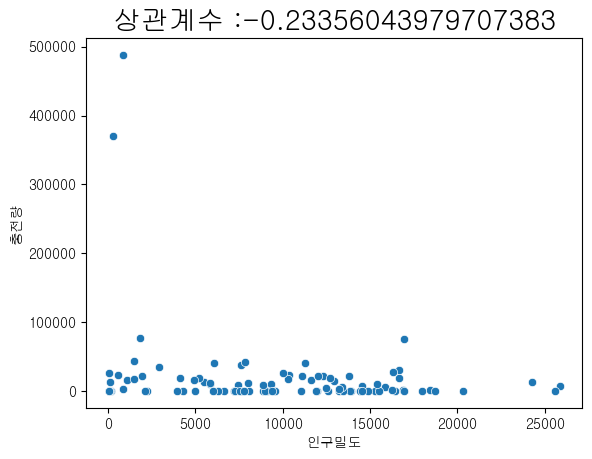

In [19]:
# 상관관계 시각화 (산점도)
sns.scatterplot(data=merged_df, x='인구밀도', y='충전량')
plt.title('상관계수 :' + str(corr), fontsize = 20)

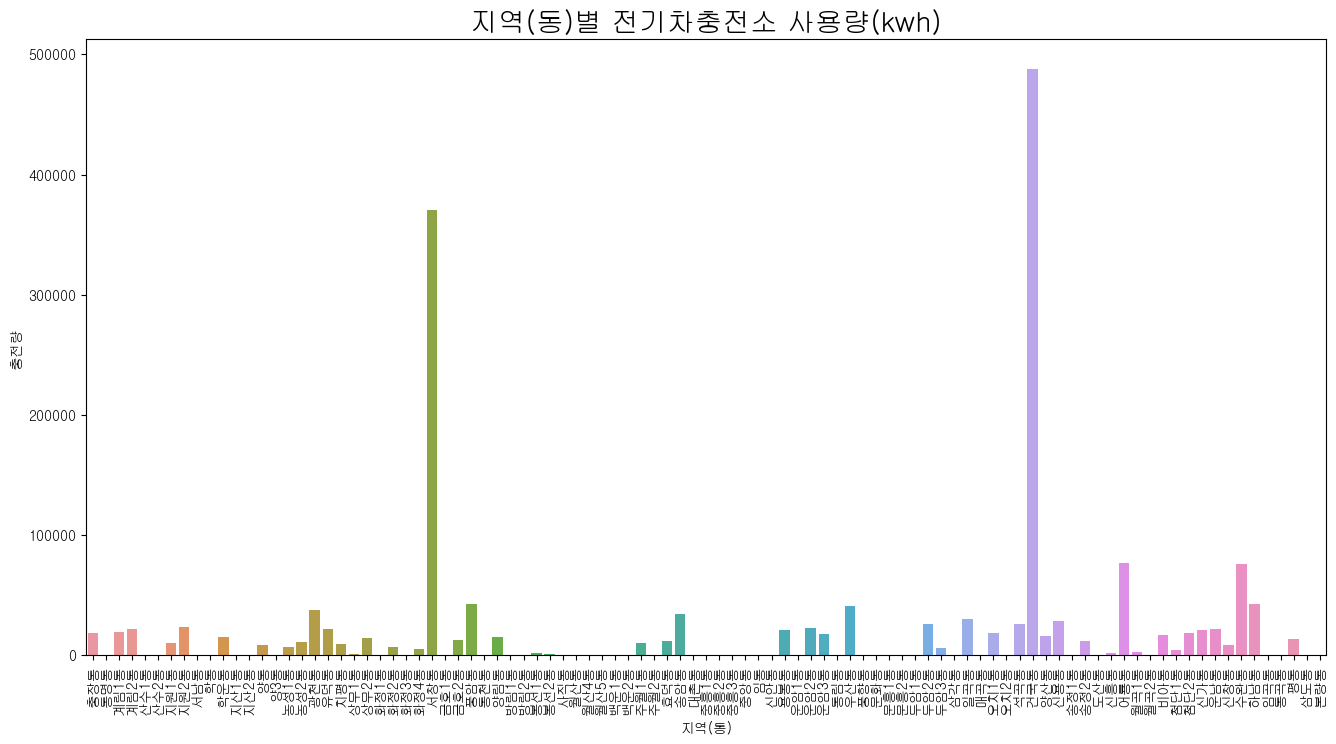

In [20]:
# 지역(동)별 전기차충전소 사용량 시각화 (막대그래프)

plt.figure(figsize = (16, 8))
sns.barplot(x = '지역(동)', y='충전량', data = merged_df)
plt.xticks(rotation = 90)
plt.title('지역(동)별 전기차충전소 사용량(kwh)', size = 20)

# annotate 함수를 사용하여 텍스트를 표시
# for i, v in enumerate(merged_df['충전량']):
#     plt.annotate(str(v), xy=(i, v), ha = 'center', va = 'bottom')

plt.show()


# ----------------------------------------------------------------- #
# 결과 : 서창동, 건국동의 사용량이 압도적으로 많음 
#    => 서창동, 건국동의 전기차충전소를 분석해보기
# ----------------------------------------------------------------- #

#### 3-1-1. 서창동과 건국동의 전기차충전소 분석

In [21]:
### 서창동과 건국동의 전기차 충전소의 '충전소명'과 각 충전소별로 '충전횟수' 구하기

# 서창동과 건국동의 데이터 추출
filtered_data = ev_usage_copy[ev_usage_copy['지역(동)'].isin(['서창동', '건국동'])]

# '지역(동)'과 '충전소명' 기준으로 그룹화하여 count
grouped_data = filtered_data.groupby(['지역(동)', '충전소명']).size().reset_index(name = '충전횟수')

# 출력
grouped_data

,지역(동),충전소명,충전횟수
0,건국동,광주테크노파크가전로봇센터,1
1,건국동,정부광주합동청사,9
2,건국동,첨단공용차고지,7689
3,건국동,한국광기술원,35
4,서창동,매월동 전기버스 충전소,8331
5,서창동,서부농수산물도매시장,23


#### -------------------------------------------------------------------------------------------------------------- #
#### 가. 서창동과 건국동의 '충전횟수'가 다른 지역(동)에 비해 훨씬 많을 것으로 예상하며  
####   ==> 지역(동)별 충전횟수 비교하기
#### 나. 충전소명'을 보아 '차고지 및 전기차 충전소'이기 때문에 '충전기수' 또한 다른 지역(동)에 비해 많을 것으로 생각됨
####   ==> 지역(동)별 충전기수 비교하기
#### 다. 충전기수와 충전량(사용량)의 관계 (충전기수가 많다고해서 충전량이 많다고 볼 순 없으니까)
#### -------------------------------------------------------------------------------------------------------------- #

#### 3-1-1-가. 서창동과 건국동의 충전횟수와 다른 지역(동)의 충전횟수 비교

In [22]:
# 전체 지역(동)의 충전소명별 충전횟수 구하기
grouped_data2 = ev_usage_copy.groupby(['지역(동)', '충전소명']).size().reset_index(name = '충전횟수')
grouped_data2

,지역(동),충전소명,충전횟수
0,건국동,광주테크노파크가전로봇센터,1
1,건국동,정부광주합동청사,9
2,건국동,첨단공용차고지,7689
3,건국동,한국광기술원,35
4,계림1동,계림동 공영주차장,3
5,계림1동,홈플러스 광주계림점,805
6,계림2동,이마트 동광주점,767
7,광천동,광천e편한세상아파트,1415
8,금호2동,금호5차호반리젠시빌,130
9,금호2동,금호동 남양파크,200


In [23]:
# 전체 지역(동)별 총충전횟수(합계)
grouped_data3 = grouped_data2.groupby(['지역(동)'])['충전횟수'].sum()
grouped_data3 = grouped_data3.reset_index()
grouped_data3

,지역(동),충전횟수
0,건국동,7734
1,계림1동,808
2,계림2동,767
3,광천동,1415
4,금호2동,556
5,농성1동,578
6,농성2동,477
7,도산동,4
8,동명동,13
9,두암2동,1017


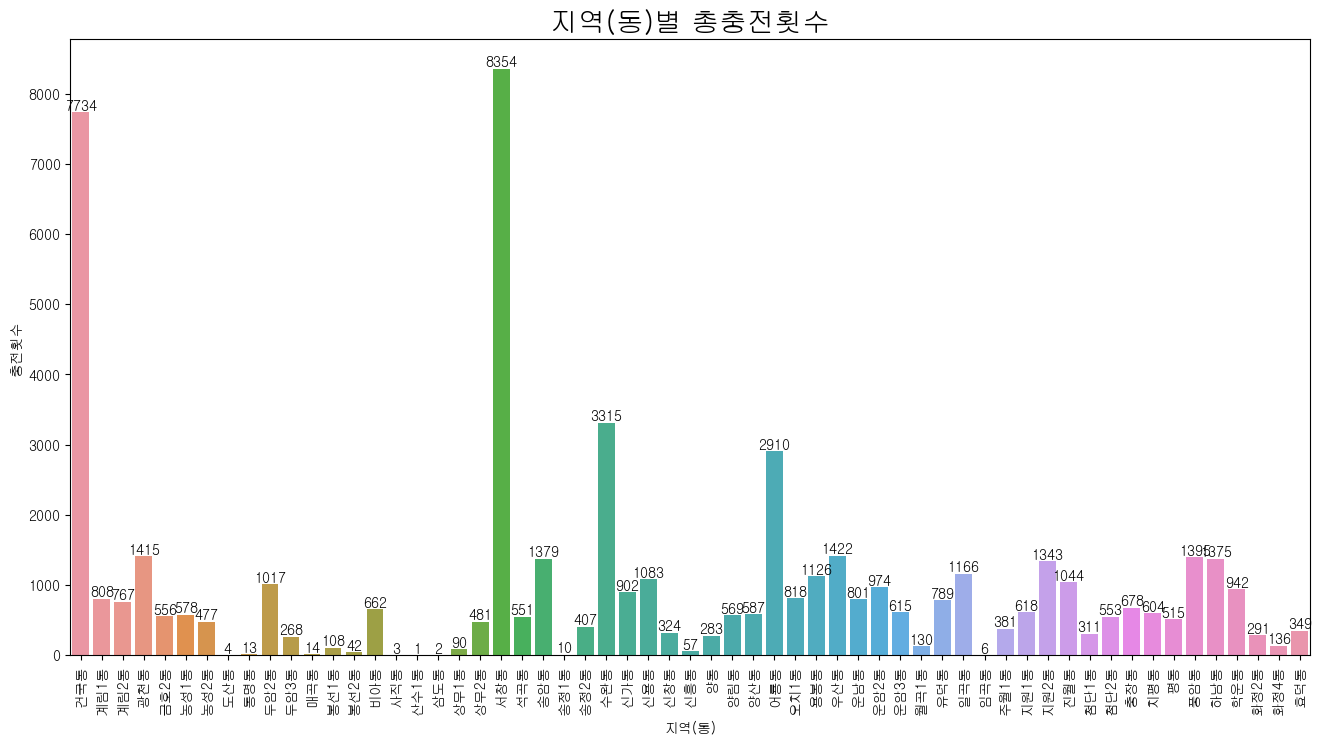

In [24]:
# 전체 지역(동)별 총충전횟수 시각화 (막대그래프)
plt.figure(figsize = (16, 8))
sns.barplot(x = '지역(동)', y='충전횟수', data = grouped_data3)
plt.xticks(rotation = 90)
plt.title('지역(동)별 총충전횟수', size = 20)

# annotate 함수를 사용하여 텍스트를 표시
for i, v in enumerate(grouped_data3['충전횟수']):
    plt.annotate(str(v), xy=(i, v), ha = 'center', va = 'bottom')

plt.show()

In [25]:
# ----------------------------------------------------------------- #
# 3-1-1-가.
# 결론 : 건국동, 서창동의 충전횟수가 다른 동보다 월등히 높다. 
# ----------------------------------------------------------------- #

#### 3-1-1-나. 지역(동)별 전기차 충전기수 구하기

In [26]:
df_by_charger_id = ev_usage_copy.groupby('충전기ID').first()              # 각 충전기ID에 대해 첫번째 row만 가져오기
charger_counts_by_location = df_by_charger_id['지역(동)'].value_counts()  # 지역(동)별 충전기개수 총합

In [27]:
# 전체 충전기 개수는 243개
df_by_charger_id.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 34 to 11005060
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  243 non-null    int64  
 1   본부          243 non-null    object 
 2   사업소         243 non-null    object 
 3   충전소명        243 non-null    object 
 4   충전기         243 non-null    object 
 5   주소          243 non-null    object 
 6   충전기구분       243 non-null    object 
 7   충전용량        243 non-null    int64  
 8   충전량         243 non-null    float64
 9   충전시간        243 non-null    float64
 10  충전분         243 non-null    int64  
 11  충전종료일자      243 non-null    object 
 12  충전시작시각      243 non-null    object 
 13  충전종료시각      243 non-null    object 
 14  지역(구)       243 non-null    object 
 15  지역(동)       243 non-null    object 
 16  충전시각        243 non-null    object 
 17  충전시각(분)     243 non-null    int64  
 18  day         243 non-null    int64  
 19  month       243 non-null    

In [28]:
# 지역(동)별 충전기개수 총합
charger_counts_by_location = charger_counts_by_location.reset_index()
charger_counts_by_location.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
지역(동),수완동,어룡동,첨단2동,송암동,하남동,신용동,학운동,오치1동,석곡동,우산동,치평동,지원2동,유덕동,일곡동,건국동,지원1동,송정2동,운암2동,농성1동,두암2동,용봉동,금호2동,광천동,신창동,효덕동,운암3동,서창동,평동,농성2동,풍암동,도산동,비아동,진월동,화정2동,상무2동,화정4동,운남동,계림1동,두암3동,상무1동,봉선2동,충장동,봉선1동,삼도동,사직동,산수1동,임곡동,동명동,매곡동,신흥동,월곡1동,첨단1동,계림2동,신가동,주월1동,양동,양산동,양림동,송정1동
count,26,19,12,11,10,8,8,7,7,7,6,6,6,6,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [29]:
charger_counts_by_location

,지역(동),count
0,수완동,26
1,어룡동,19
2,첨단2동,12
3,송암동,11
4,하남동,10
5,신용동,8
6,학운동,8
7,오치1동,7
8,석곡동,7
9,우산동,7


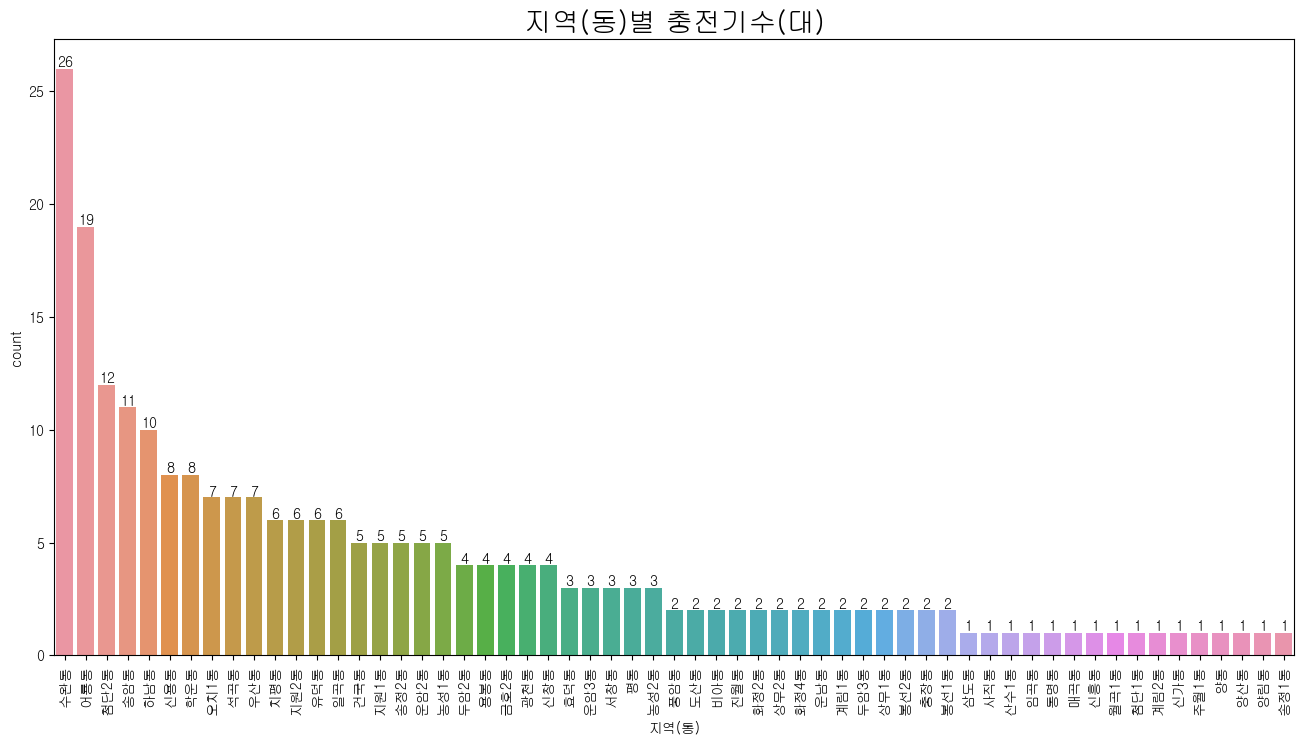

In [30]:
# 전체 지역(동)별 충전기수 시각화 (막대그래프)
plt.figure(figsize = (16, 8))
sns.barplot(x = '지역(동)', y='count', data = charger_counts_by_location)
plt.xticks(rotation = 90)
plt.title('지역(동)별 충전기수(대)', size = 20)

# annotate 함수를 사용하여 텍스트를 표시
for i, v in enumerate(charger_counts_by_location['count']):
    plt.annotate(str(v), xy=(i, v), ha = 'center', va = 'bottom')

plt.show()

In [79]:
### 인구밀도와 전기차충전기 개수의 상관관계(이상치제거 X)
combined_df2 = pd.merge(merged_df, charger_counts_by_location, how = 'inner', on='지역(동)')
combined_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량,count
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060,2
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690,1
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420,2
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420,1
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240,1
5,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610,5
6,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180,6
7,광주광역시,동구,학운동,11897,10.80,1101.574074,15523.670,8
8,광주광역시,서구,양동,4015,0.54,7435.185185,9013.190,1
9,광주광역시,서구,농성1동,11071,0.76,14567.105260,6998.556,5


Text(0.5, 1.0, '상관계수 :-0.07353073226310451')

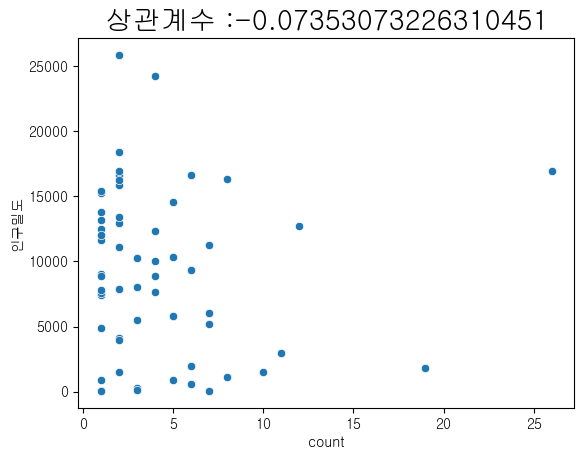

In [32]:
# 상관계수 산점도
corr_count_density = combined_df2['count'].corr(combined_df2['인구밀도'])
sns.scatterplot(data=combined_df2,  x='count', y='인구밀도')
plt.title('상관계수 :' + str(corr_count_density), fontsize = 20)

In [33]:
# 지역(동)별 충전기ID의 충전기유형(급속/완속)
charger_type = ev_usage_copy.groupby(['지역(동)', '충전기ID', '충전기구분'])['충전기구분'].count().to_frame()
charger_type

충전기구분
지역(동) 충전기ID    충전기구분       
건국동   8847     급속      3584
      8848     급속      4105
      11002199 급속        35
      11003962 급속         9
      11004073 급속         1
계림1동  6039     급속       805
      11002939 급속         3
계림2동  6038     급속       767
광천동   8506     급속       360
      8507     완속       415
      8508     완속       440
      8509     완속       200
금호2동  7691     완속       130
      8262     완속       161
      8263     완속        39
      8332     완속       226
농성1동  271      급속       174
      273      완속        99
      483      완속       152
      484      완속       151
      11002823 급속         2
농성2동  1015     급속       289
      1016     완속        91
      1017     완속        97
도산동   10614    급속         2
      10615    급속         2
동명동   11004069 급속        13
두암2동  6041     급속       940
      6612     급속        19
      6613     완속        45
      6614     완속        13
두암3동  4677     완속       129
      4678     완속       139
매곡동   11002952 급속        14
봉선1동  2058     완속       102
      11004068 급속         6
봉선2동  4669     급속        32
      11004074 급속        10
비아동   696      급속       659
      11002936 급속         3
사직동   11002938 급속         3
산수1동  11004070 급속         1
삼도동   11003961 급속         2
상무1동  9332     완속        89
      11002943 급속         1
상무2동  8181     급속       269
      8182     급속       212
서창동   8849     급속      4182
      8850     급속      4149
      11004066 급속        23
석곡동   10417    급속        62
      10418    급속       138
      10419    급속       203
      10420    급속       140
      11000326 급속         6
      11002941 급속         1
      11002987 급속         1
송암동   4670     완속       147
      4671     완속       150
      8462     급속       518
      9007     완속        95
      9008     완속        23
      9009     완속        76
      9010     완속       153
      9011     완속        88
      9012     완속       122
      11000324 급속         2
      11005060 급속         5
송정1동  11004072 급속        10
송정2동  34       급속       233
      9003     완속        59
      9004     완속        40
      9005     완속        65
      11004067 급속        10
수완동   697      급속       879
      2700     완속       251
      2701     완속       308
      5634     급속        24
      6328     급속        42
      6329     완속       455
      6330     완속       356
      7403     완속       169
      7404     완속        72
      7556     완속        40
      7557     완속       115
      7558     완속       222
      7559     급속       136
      8528     급속        89
      8996     완속        16
      8997     완속         7
      8998     완속        28
      8999     완속        23
      9000     완속         8
      9001     완속        24
      9887     완속        11
      9888     완속         5
      9889     완속         8
      9890     완속        16
      11002261 급속         8
      11004850 급속         3
신가동   5999     급속       902
신용동   6345     급속       111
      6346     완속       130
      7798     급속       305
      8463     완속        23
      8464     완속       120
      8465     완속        59
      8466     완속       146
      8467     완속       189
신창동   2062     급속        41
      8329     급속        34
      9535     급속       248
      11002751 급속         1
신흥동   5638     급속        57
양동    1198     급속       283
양림동   694      급속       569
양산동   1194     급속       587
어룡동   251      완속        53
      252      완속        58
      476      급속       478
      976      완속        18
      977      완속        59
      978      완속        66
      979      급속       670
      2059     급속       107
      2060     완속        58
      2061     완속       116
      2697     급속        15
      2698     완속        16
      2699     완속        49
      8259     완속       257
      8260     완속       204
      8261     완속       181
      8326     완속       156
      8327     완속       182
      8328     완속       167
오치1동  253      급속       591
      254      완속        52
      255      완속        94
      256      완속        51
      973      완속        24
      974      완속 

In [34]:
# ---------------------------------------------------------------------------------------------------------------------------------- #
# 3-1-1-나.결론  
#  1. 건국동, 서창동의 충전횟수가 다른 동보다 월등히 높지만 충전기수는 가장 많이 설치된 수완동에 비해 적은 수치이다.
#  ==> 이유 : 건국동, 서창동의 충전기는 모두 급속충전기이기 때문이다. 수완동은 급속(7개)/완속충전기(19개) 설치됨. 
#  2. 인구밀도가 많은 곳에 전기차 충전기수가 많은 것은 아니다. => 상관관계 : 약 -0.07
#  ==> 한계점 : 한전 데이터 이외에 민간업체에서 설치한 전기차 충전소 데이터가 포함되지 않았다. 
# ---------------------------------------------------------------------------------------------------------------------------------- #

#### 3-1-1-다. 충전기수와 충전량(사용량)의 관계

Text(0.5, 1.0, '상관계수 :0.16546373359452574')

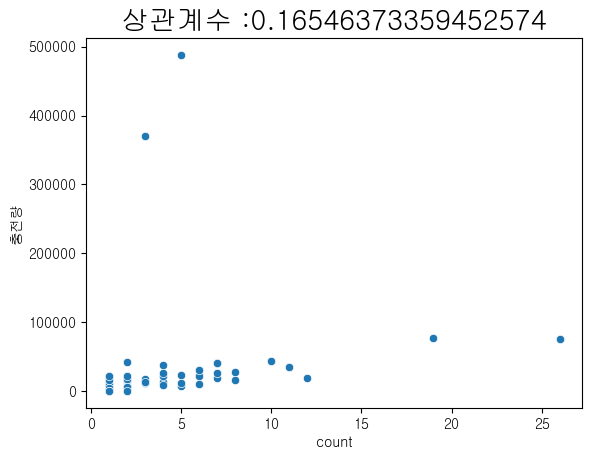

In [35]:
corr_count_usage = combined_df2['count'].corr(combined_df2['충전량'])

sns.scatterplot(data=combined_df2,  x='count', y='충전량')
plt.title('상관계수 :' + str(corr_count_usage), fontsize = 20)

In [80]:
### 인구밀도와 전기차충전기 개수의 상관관계(이상치제거 O)
combined_df3 = pd.merge(merged_df2, charger_counts_by_location, how = 'inner', on='지역(동)')
combined_df3

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량,충전기수,충전횟수,count
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060,2.0,678.0,2
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690,1.0,13.0,1
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420,2.0,808.0,2
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420,1.0,767.0,1
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240,1.0,1.0,1
5,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610,5.0,618.0,5
6,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180,6.0,1343.0,6
7,광주광역시,동구,학운동,11897,10.80,1101.574074,15523.670,8.0,942.0,8
8,광주광역시,서구,양동,4015,0.54,7435.185185,9013.190,1.0,283.0,1
9,광주광역시,서구,농성1동,11071,0.76,14567.105260,6998.556,5.0,578.0,5


Text(0.5, 1.0, '상관계수 :0.7986129508089747')

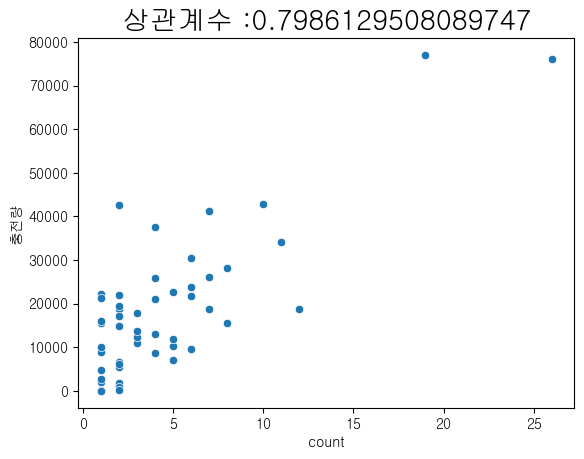

In [82]:
# 이상치 제거한 충전량과 충전기수의 상관관계 산점도
corr_count_usage_drop = combined_df3['count'].corr(combined_df3['충전량'])

sns.scatterplot(data=combined_df3,  x='count', y='충전량')
plt.title('상관계수 :' + str(corr_count_usage_drop), fontsize = 20)

In [36]:
# ---------------------------------------------------------------------------------------------------------------------------------- #
# 3-1-1-다.결론  
#  1. 지역(동)별 충전기수와 충전량과는 상관관계가 있다.(이상치 제거할 경우)
# ---------------------------------------------------------------------------------------------------------------------------------- #

#### 3-2. 서창동, 건국동 제외한 '지역(동)'별 인구밀도와 전기차 충전소 사용량과의 상관관계 구하기

In [37]:
# 서창동, 건국동 빼고 df생성하기
merged_df2 = merged_df.drop(merged_df[merged_df['지역(동)'].isin(['서창동', '건국동'])].index)
merged_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량
0,광주광역시,동구,충장동,"4,546",1.10,4132.727273,18866.060
1,광주광역시,동구,동명동,"3,873",0.43,9006.976744,87.690
2,광주광역시,동구,계림1동,"10,323",0.62,16650.000000,19420.420
3,광주광역시,동구,계림2동,"7,859",0.57,13787.719300,22192.420
4,광주광역시,동구,산수1동,"8,850",0.58,15258.620690,31.240
5,광주광역시,동구,산수2동,"10,401",0.87,11955.172410,0.000
6,광주광역시,동구,지원1동,"8,000",1.37,5839.416058,10388.610
7,광주광역시,동구,지원2동,"16,594",27.69,599.277718,23762.180
8,광주광역시,동구,서남동,"3,230",1.44,2243.055556,0.000
9,광주광역시,동구,학동,"8,167",1.23,6639.837398,0.000


In [38]:
# 서창동, 건국동 제외한 상관관계 구하기
corr2 = merged_df2['인구밀도'].corr(merged_df2['충전량'])
corr2

-0.12035939364103479

Text(0.5, 1.0, '상관계수 :-0.12035939364103479')

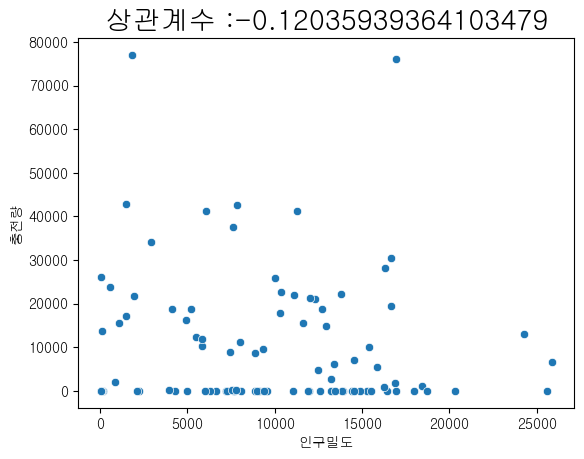

In [39]:
# 상관관계 시각화 (산점도)
sns.scatterplot(data=merged_df2, x='인구밀도', y='충전량')
plt.title('상관계수 :' + str(corr2), fontsize = 20)

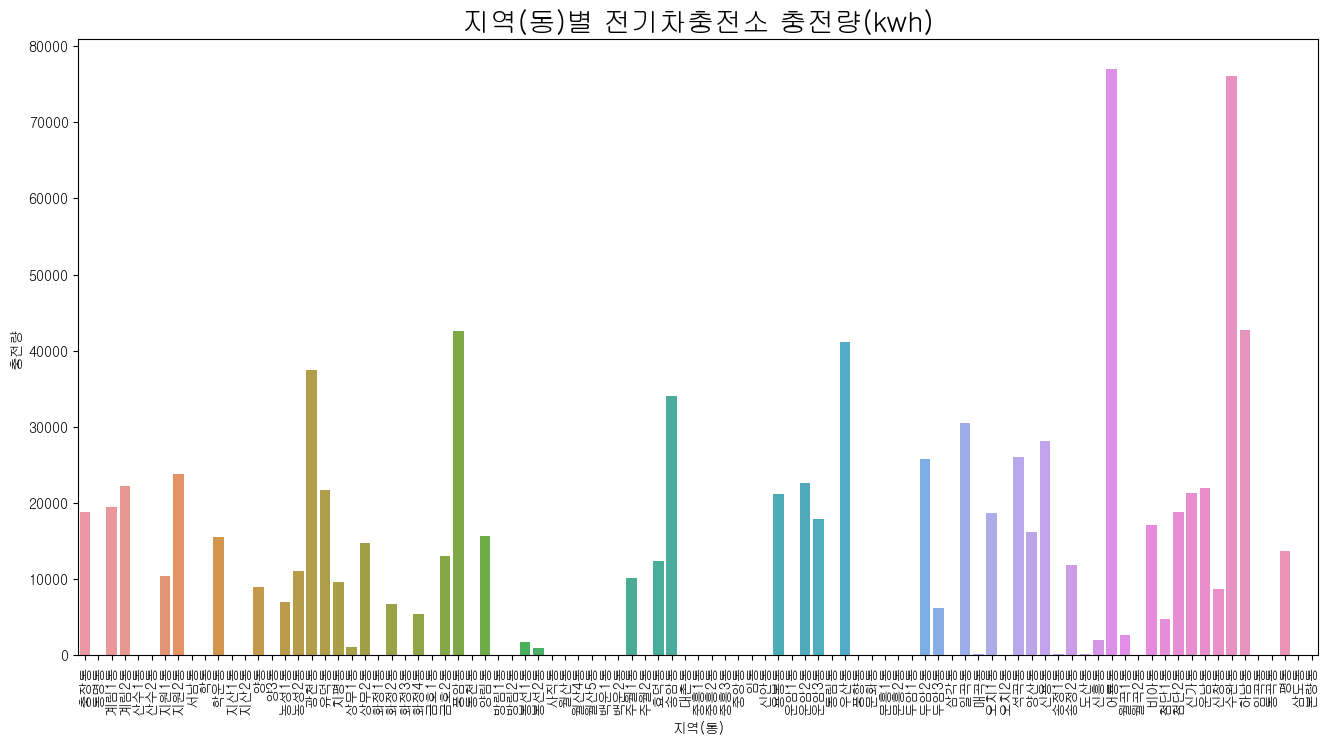

In [40]:
# 지역(동)별 전기차충전소 사용량 시각화 (막대그래프)
plt.figure(figsize=(16, 8))
sns.barplot(x='지역(동)', y='충전량', data=merged_df2)
plt.xticks(rotation=90)
plt.title('지역(동)별 전기차충전소 충전량(kwh)', size = 20)
plt.show()

### 4. 지역(동)별 인구수와 전기차 충전량과의 상관관계

##### 광산구의 인구수(405,579)는 북구와 비슷하지만 면적(222.79)이 넓어 인구밀도(1820.45)가 가장 작다.
##### 반면에 서구는 면적(47.76)이 가장 작지만 면적대비 인구수(296,576)가 많아 인구밀도(6209.71)가 가장 높다.
##### 앞선 분석 결과 인구밀도와 전기차 충전소의 사용량과의 상관관계가 없다고 판명되었지만
##### 각 지역(구)의 행정동별 인구수의 차이에 따른 충전량(사용량)과의 연관성이 있을 수 있기에 이를 조사해 보고자 한다.
##### ex) 예상 : 지역(동) 중에 전기차 충전소 수가 많은 곳은 인구수가 많은 주거밀집지역일 것이며 충전량 또한 높을 것이다.

### 4-1. 지역(동)별 인구수 및 전기차 사용량 상관관계 및 트윈그래프

In [41]:
# # '인구' column의 type을 object -> int로 변환하기 : sort_values하기 위해
merged_df['인구'] = merged_df['인구'].str.replace(',','').astype('int')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 95
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시도명     96 non-null     object 
 1   행정기관    96 non-null     object 
 2   지역(동)   96 non-null     object 
 3   인구      96 non-null     int32  
 4   면적      96 non-null     float64
 5   인구밀도    96 non-null     float64
 6   충전량     96 non-null     float64
dtypes: float64(3), int32(1), object(3)
memory usage: 7.7+ KB


In [42]:
# # '인구' column의 type을 object -> int로 변환하기 : sort_values하기 위해
merged_df2['인구'] = merged_df2['인구'].str.replace(',','').astype('int')
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 0 to 95
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시도명     94 non-null     object 
 1   행정기관    94 non-null     object 
 2   지역(동)   94 non-null     object 
 3   인구      94 non-null     int32  
 4   면적      94 non-null     float64
 5   인구밀도    94 non-null     float64
 6   충전량     94 non-null     float64
dtypes: float64(3), int32(1), object(3)
memory usage: 5.5+ KB


In [73]:
# 인구수와 전기차 사용량 상관관계(이상치(서창동, 건국동) 제거X)
corr_population_usage_nondrop = merged_df['인구'].corr(merged_df['충전량'])
corr_population_usage_nondrop

0.1387203402592099

Text(0.5, 1.0, '상관계수 :0.1387203402592099')

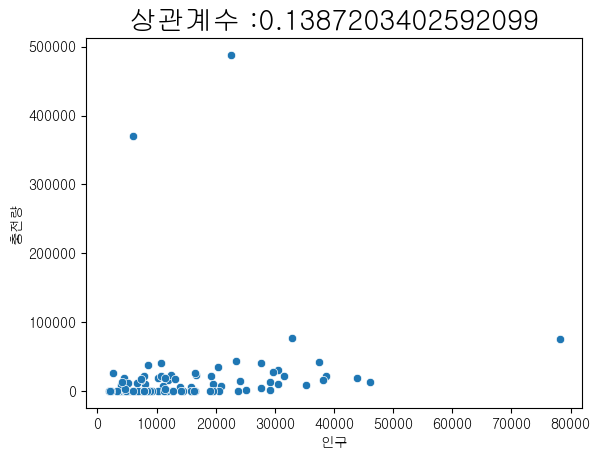

In [75]:
sns.scatterplot(data=merged_df, x='인구', y='충전량')
plt.title('상관계수 :' + str(corr_population_usage_nondrop), fontsize = 20)

In [74]:
# 인구수와 전기차 사용량 상관관계(이상치(서창동, 건국동) 제거O)
corr_population_usage = merged_df2['인구'].corr(merged_df2['충전량'])
corr_population_usage

0.5446312694980234

Text(0.5, 1.0, '상관계수 :0.5567257622340005')

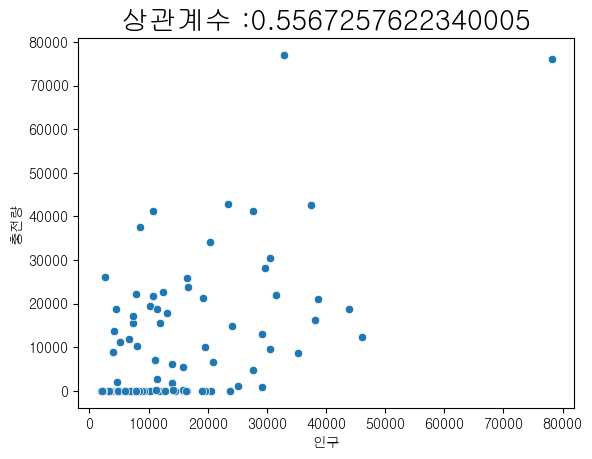

In [44]:
sns.scatterplot(data=merged_df2, x='인구', y='충전량')
plt.title('상관계수 :' + str(corr_population_usage), fontsize = 20)

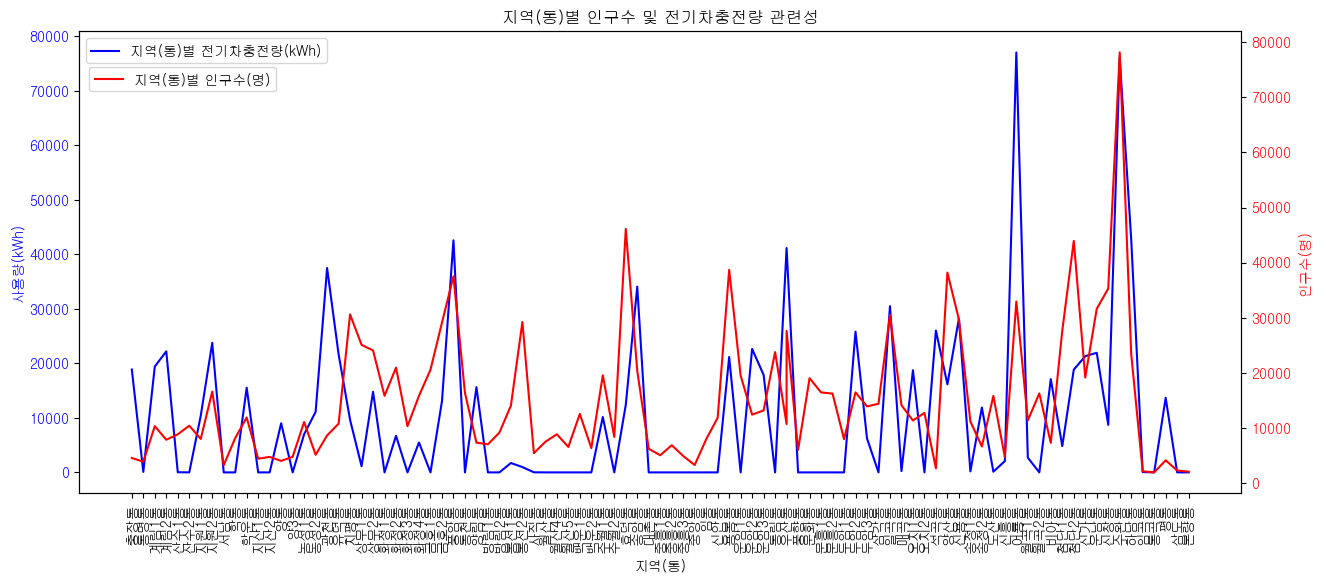

In [45]:
# 사용량 수치가 너무 큰 값((서창동, 건국동)을 제외한 그래프

plt.figure(figsize=(15, 6))
ax1 = plt.gca() # 현재 축 가져오기
ax1.plot(merged_df2['지역(동)'], merged_df2['충전량'], 'b-', label='지역(동)별 전기차충전량(kWh)')
ax1.set_xlabel('지역(동)')
ax1.set_ylabel('사용량(kWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.xticks(rotation=90)
plt.legend(loc='upper left')

ax2 = ax1.twinx() # x축을 공유하는 쌍둥이 축 만들기
ax2.plot(merged_df2['지역(동)'], merged_df2['인구'], 'r-', label='지역(동)별 인구수(명)')
ax2.set_ylabel('인구수(명)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.legend(loc=(0.009,0.87))

plt.title('지역(동)별 인구수 및 전기차충전량 관련성')
plt.show()

In [46]:
# merged_df2.sort_values

In [47]:
# merged_df2['인구'].sort_values(ascending = True).to_frame()

In [48]:
# ------------------------------------------------------------------------------------------------------------------------------------------ #
# 4-1. 결론 : 인구수와 전기차 충전기 사용량은 상관계수가 높다.
# ==>  한계 : 현재 전기차충전소 충전량의 데이터는 한전에서 설치한 충전기 자료만 해당하기 때문에 사용량이 0인 지역(동)이 존재한다는 한계가 있다.
# ------------------------------------------------------------------------------------------------------------------------------------------ #

### 4-2. 지역(동)별 인구수와 인구밀도와의 상관관계

In [49]:
# # '인구' column의 type을 object -> int로 변환하기 : sort_values하기 위해
# merged_df2['인구'] = merged_df2['인구'].str.replace(',','').astype('int')
# merged_df2.info()

In [50]:
merged_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240
5,광주광역시,동구,산수2동,10401,0.87,11955.172410,0.000
6,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610
7,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180
8,광주광역시,동구,서남동,3230,1.44,2243.055556,0.000
9,광주광역시,동구,학동,8167,1.23,6639.837398,0.000


In [77]:
corr_population_density = merged_df2['인구밀도'].corr(merged_df2['인구'])
corr_population_density

0.25213017095821577

Text(0.5, 1.0, '상관계수 :0.25213017095821577')

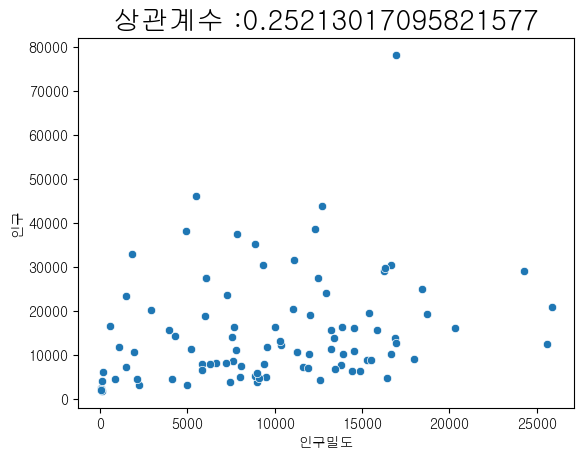

In [78]:
sns.scatterplot(data = merged_df2, x='인구밀도', y='인구')
plt.title('상관계수 :' + str(corr_population_density), fontsize = 20)

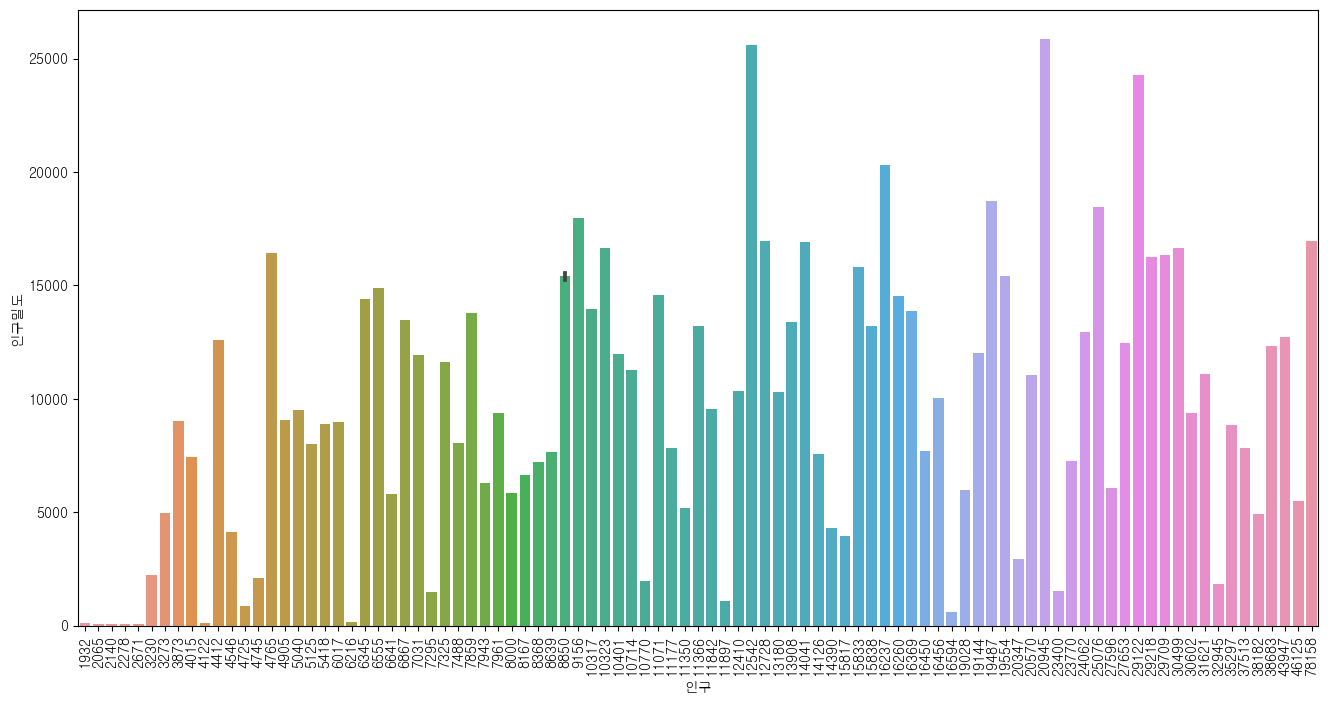

In [53]:
plt.figure(figsize=(16, 8))
sns.barplot(x='인구', y='인구밀도', data = merged_df2)
plt.xticks(rotation=90)
plt.show()

In [83]:
# 인구-인구밀도 상관관계 (이상치제거x)
corr_population_density_nondrop = merged_df['인구밀도'].corr(merged_df['인구'])
corr_population_density_nondrop

0.2573166733735464

Text(0.5, 1.0, '상관계수 :0.2573166733735464')

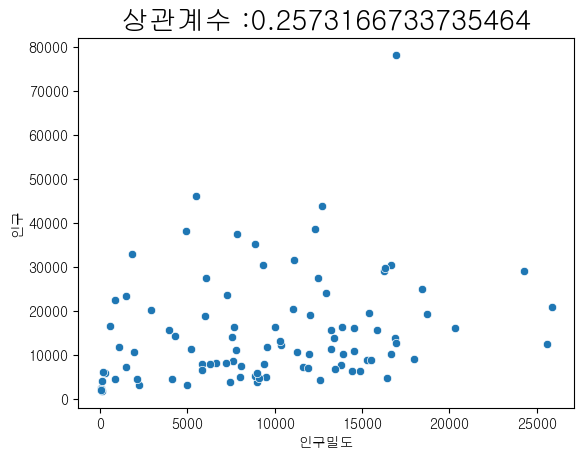

In [84]:
# 인구-인구밀도 상관관계 (이상치제거x)
sns.scatterplot(data = merged_df, x='인구밀도', y='인구')
plt.title('상관계수 :' + str(corr_population_density_nondrop), fontsize = 20)

In [54]:
# ------------------------------------------------------------------------------------------------------------------------------------------ #
# 4-2. 결론 : 지역(동)별 인구수와 인구밀도는 상관관계가 낮다.
# ==>  한계 : 현재 전기차충전소 충전량의 데이터는 한전에서 설치한 충전기 자료만 해당하기 때문에 사용량이 0인 지역(동)이 존재한다는 한계가 있다.
# ------------------------------------------------------------------------------------------------------------------------------------------ #

In [55]:
## 아쉬운점 : 지역(동)의 유동인구와 충전량(사용량)과의 관계를 조사해보고자 했으나 지역(구)단위의 유동인구총합 데이터만 있음

### 4-3. heatmap 시각화하기

In [56]:
merged_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240
5,광주광역시,동구,산수2동,10401,0.87,11955.172410,0.000
6,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610
7,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180
8,광주광역시,동구,서남동,3230,1.44,2243.055556,0.000
9,광주광역시,동구,학동,8167,1.23,6639.837398,0.000


In [57]:
# 열이름 변경하기
combined_df2 = combined_df2.rename(columns = { 'count' : '충전기수'})

In [58]:
# 충전횟수(열)이 있는 df
grouped_data3

,지역(동),충전횟수
0,건국동,7734
1,계림1동,808
2,계림2동,767
3,광천동,1415
4,금호2동,556
5,농성1동,578
6,농성2동,477
7,도산동,4
8,동명동,13
9,두암2동,1017


In [59]:
# 충전기수 merge
merged_df2 = pd.merge(merged_df2, combined_df2[['지역(동)', '충전기수']],  on='지역(동)', how='left')
merged_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량,충전기수
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060,2.0
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690,1.0
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420,2.0
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420,1.0
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240,1.0
5,광주광역시,동구,산수2동,10401,0.87,11955.172410,0.000,NaN
6,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610,5.0
7,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180,6.0
8,광주광역시,동구,서남동,3230,1.44,2243.055556,0.000,NaN
9,광주광역시,동구,학동,8167,1.23,6639.837398,0.000,NaN


In [60]:
# 결측값 제거
merged_df2.loc[pd.isna(merged_df2['충전기수']), '충전기수'] = 0
merged_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량,충전기수
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060,2.0
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690,1.0
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420,2.0
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420,1.0
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240,1.0
5,광주광역시,동구,산수2동,10401,0.87,11955.172410,0.000,0.0
6,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610,5.0
7,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180,6.0
8,광주광역시,동구,서남동,3230,1.44,2243.055556,0.000,0.0
9,광주광역시,동구,학동,8167,1.23,6639.837398,0.000,0.0


In [61]:
# 충전횟수 merge
merged_df2 = pd.merge(merged_df2, grouped_data3[['지역(동)', '충전횟수']],  on='지역(동)', how='left')
merged_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량,충전기수,충전횟수
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060,2.0,678.0
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690,1.0,13.0
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420,2.0,808.0
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420,1.0,767.0
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240,1.0,1.0
5,광주광역시,동구,산수2동,10401,0.87,11955.172410,0.000,0.0,NaN
6,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610,5.0,618.0
7,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180,6.0,1343.0
8,광주광역시,동구,서남동,3230,1.44,2243.055556,0.000,0.0,NaN
9,광주광역시,동구,학동,8167,1.23,6639.837398,0.000,0.0,NaN


In [62]:
# 결측값 제거
merged_df2.loc[pd.isna(merged_df2['충전횟수']), '충전횟수'] = 0
merged_df2

,시도명,행정기관,지역(동),인구,면적,인구밀도,충전량,충전기수,충전횟수
0,광주광역시,동구,충장동,4546,1.10,4132.727273,18866.060,2.0,678.0
1,광주광역시,동구,동명동,3873,0.43,9006.976744,87.690,1.0,13.0
2,광주광역시,동구,계림1동,10323,0.62,16650.000000,19420.420,2.0,808.0
3,광주광역시,동구,계림2동,7859,0.57,13787.719300,22192.420,1.0,767.0
4,광주광역시,동구,산수1동,8850,0.58,15258.620690,31.240,1.0,1.0
5,광주광역시,동구,산수2동,10401,0.87,11955.172410,0.000,0.0,0.0
6,광주광역시,동구,지원1동,8000,1.37,5839.416058,10388.610,5.0,618.0
7,광주광역시,동구,지원2동,16594,27.69,599.277718,23762.180,6.0,1343.0
8,광주광역시,동구,서남동,3230,1.44,2243.055556,0.000,0.0,0.0
9,광주광역시,동구,학동,8167,1.23,6639.837398,0.000,0.0,0.0


<AxesSubplot: >

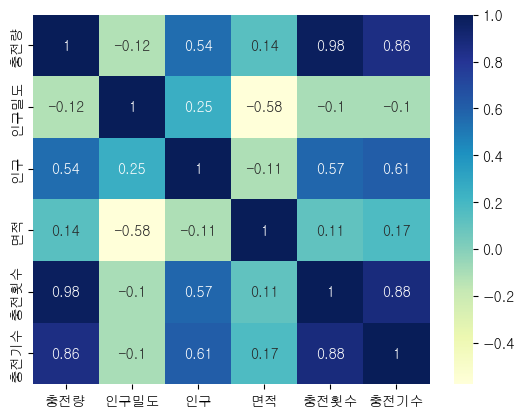

In [85]:
# 상관계수 구하기
corr_matrix = merged_df2[['충전량','인구밀도', '인구', '면적', '충전횟수', '충전기수']].corr()

# 시각화
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

### 5. 회귀모델 

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

In [100]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 데이터 전처리
df = merged_df2[['인구', '충전량']]
X = df[['인구']]  # 독립 변수
y = df['충전량']  # 종속 변수

# train과 test 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 회귀분석 모델 선택
model = LinearRegression()

# 모델 학습
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-squared score:', r2)

# 모델 적용
new_population = pd.DataFrame({'인구': [4546, 10323, 29218]})
predicted_charges = model.predict(new_population)
print('Predicted charges:', predicted_charges)


R-squared score: 0.19516247764737937
Predicted charges: [ 3086.36414495  7125.35174791 20335.78462968]


In [101]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 데이터 전처리
df = merged_df2[['충전횟수', '충전량']]
X = df[['충전횟수']]  # 독립 변수
y = df['충전량']  # 종속 변수

# train과 test 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 회귀분석 모델 선택
model = LinearRegression()

# 모델 학습
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-squared score:', r2)

# 모델 적용
new_population = pd.DataFrame({'충전횟수': [678, 13, 2910]})
predicted_charges = model.predict(new_population)
print('Predicted charges:', predicted_charges)


R-squared score: 0.9590654452585252
Predicted charges: [17100.13916744   378.02955021 73226.07701054]


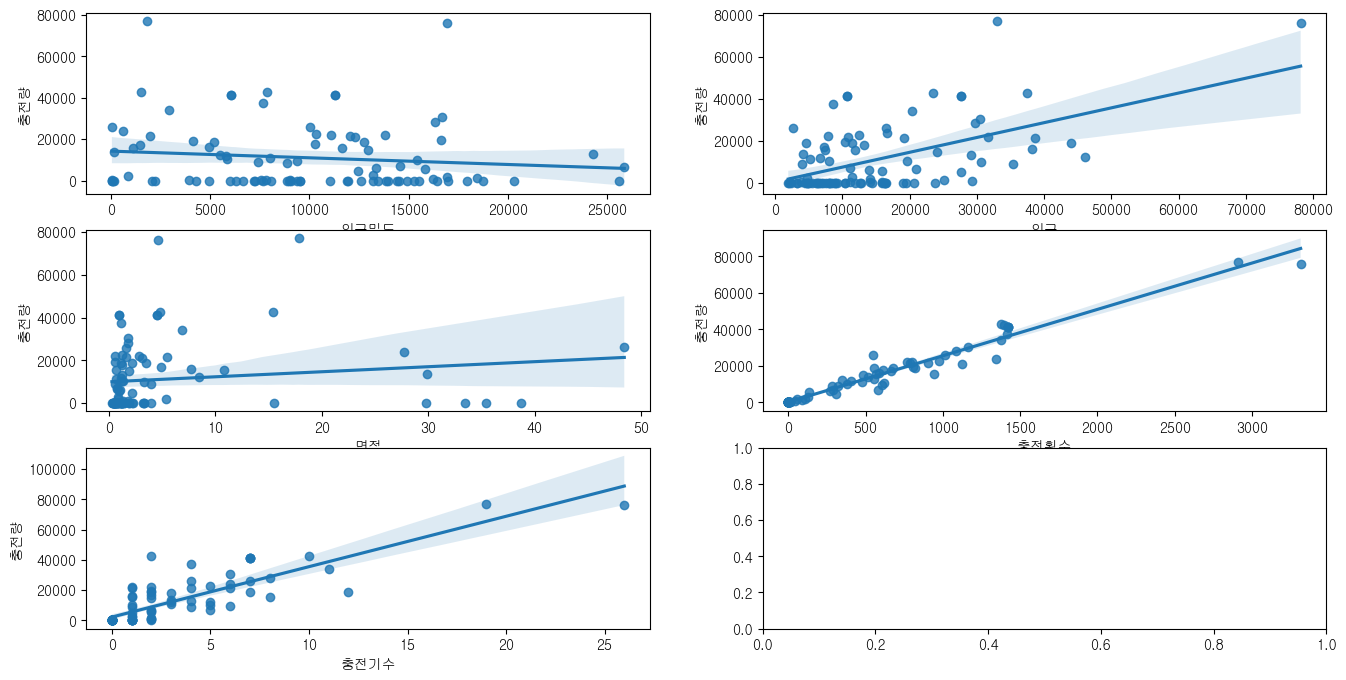

In [106]:
# 독립변수들 사이의 회귀값 확인하기
# figsize(단위 : 인치),  3행 x 2열 
fig, axs = plt.subplots(figsize = (16, 8), nrows = 3, ncols = 2)

# features == columns
lm_features = ['인구밀도', '인구', '면적', '충전횟수', '충전기수']

# 충전량(종속변수)과 5개의 컬럼값(독립변수)에 대한 관계성 확인
for i, feature in enumerate(lm_features):
    # axs에 접근하는 방법 : axs[행][열]
    # i = 0 ~ 4, features : 데이터
    
    # row : 0 ~ 2 : 0 ,  3 ~ 5 : 1
    row = int(i / 2)
    
    # col : 0, 1 / 0, 1 / 0, 1
    col = i % 2 
    
    sns.regplot(x = feature , y = '충전량', data = merged_df2, ax = axs[row][col])
